In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.datasets import make_moons
from sklearn.ensemble._bagging import BaggingClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator

import torch
import torch.nn as nn
import torch.nn.functional as F

%matplotlib inline

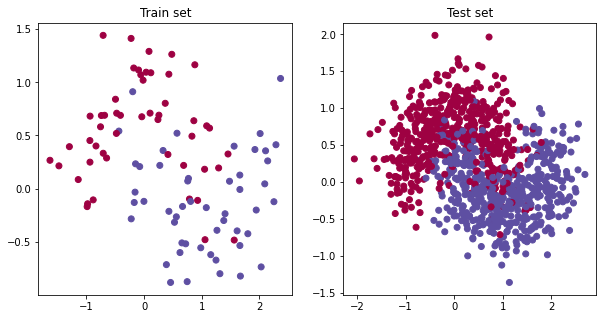

In [2]:
np.random.seed(16)
tr_x, tr_y = make_moons(100, noise=0.3)
ts_x, ts_y = make_moons(1000, noise=0.3)

xx, yy = np.meshgrid(np.arange(-2, 3, 0.05), np.arange(-1.5, 2.0, 0.05))
zz = np.concatenate([xx.ravel()[:, np.newaxis], yy.ravel()[:, np.newaxis]], axis=1)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].scatter(tr_x[:,0], tr_x[:,1], c=tr_y, cmap=plt.cm.Spectral)
axs[0].set_title('Train set')
axs[1].scatter(ts_x[:,0], ts_x[:,1], c=ts_y, cmap=plt.cm.Spectral)
axs[1].set_title('Test set')
plt.show()

In [3]:
clf_svc = SVC(C=10000, gamma='scale', probability=True)  # Support vector classifier
clf_dt = DecisionTreeClassifier()                        # Decision tree
clf_lr = LogisticRegression()                            # Logistic regressor

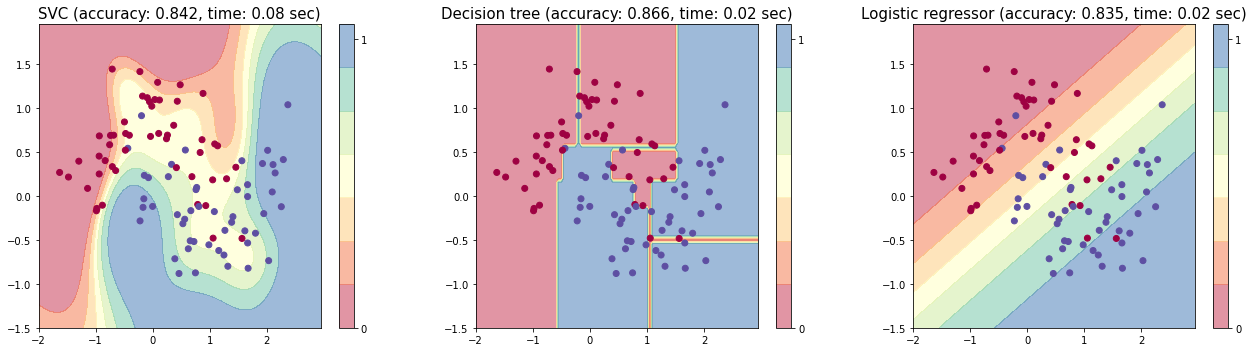

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

clf, axs_no = clf_svc, 0
time_now = time.time()
clf.fit(tr_x, tr_y)
p = clf.predict_proba(zz)
p = p.reshape((xx.shape[0], xx.shape[1], 2))
cax = axs[axs_no].contourf(xx, yy, p[:,:,1], alpha=0.5, cmap=plt.cm.Spectral)
cbar = plt.colorbar(cax, ticks=[-1, 0, 1], ax=axs[axs_no])
axs[axs_no].scatter(tr_x[:,0], tr_x[:,1], c=tr_y,cmap=plt.cm.Spectral)
axs[axs_no].set_title(f'SVC (accuracy: {clf.score(ts_x, ts_y)}, time: {(time.time() - time_now):.2f} sec)', fontsize=15)

clf, axs_no = clf_dt, 1
time_now = time.time()
clf.fit(tr_x, tr_y)
p = clf.predict_proba(zz)
p = p.reshape((xx.shape[0], xx.shape[1], 2))
cax = axs[axs_no].contourf(xx, yy, p[:,:,1], alpha=0.5, cmap=plt.cm.Spectral)
cbar = plt.colorbar(cax, ticks=[-1, 0, 1], ax=axs[axs_no])
axs[axs_no].scatter(tr_x[:,0], tr_x[:,1], c=tr_y,cmap=plt.cm.Spectral)
axs[axs_no].set_title(f'Decision tree (accuracy: {clf.score(ts_x, ts_y)}, time: {(time.time() - time_now):.2f} sec)', fontsize=15)

clf, axs_no = clf_lr, 2
time_now = time.time()
clf.fit(tr_x, tr_y)
p = clf.predict_proba(zz)
p = p.reshape((xx.shape[0], xx.shape[1], 2))
cax = axs[axs_no].contourf(xx, yy, p[:,:,1], alpha=0.5, cmap=plt.cm.Spectral)
cbar = plt.colorbar(cax, ticks=[-1, 0, 1], ax=axs[axs_no])
axs[axs_no].scatter(tr_x[:,0], tr_x[:,1], c=tr_y,cmap=plt.cm.Spectral)
axs[axs_no].set_title(f'Logistic regressor (accuracy: {clf.score(ts_x, ts_y)}, time: {(time.time() - time_now):.2f} sec)', fontsize=15)

plt.tight_layout()

# Voting

Text(0.5, 1.0, 'Soft voting (accuracy: 0.875, time: 0.11 sec)')

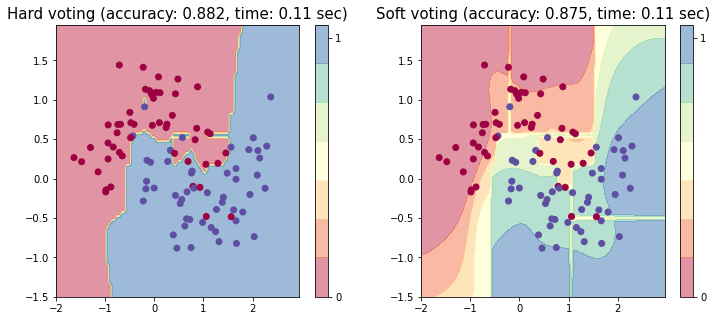

In [5]:
clf_1 = VotingClassifier(estimators=[('lr', clf_svc), ('rf', clf_dt), ('gnb', clf_lr)], voting='hard')
clf_2 = VotingClassifier(estimators=[('lr', clf_svc), ('rf', clf_dt), ('gnb', clf_lr)], voting='soft')

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

clf, axs_no = clf_1, 0
time_now = time.time()
clf.fit(tr_x, tr_y)
p = clf.predict(zz)
p = p.reshape((xx.shape[0], xx.shape[1]))
cax = axs[axs_no].contourf(xx, yy, p[:,:], alpha=0.5, cmap=plt.cm.Spectral)
cbar = plt.colorbar(cax, ticks=[-1, 0, 1], ax=axs[axs_no])
axs[axs_no].scatter(tr_x[:,0], tr_x[:,1], c=tr_y,cmap=plt.cm.Spectral)
axs[axs_no].set_title(f'Hard voting (accuracy: {clf.score(ts_x, ts_y)}, time: {(time.time() - time_now):.2f} sec)', fontsize=15)

clf, axs_no = clf_2, 1
time_now = time.time()
clf.fit(tr_x, tr_y)
p = clf.predict_proba(zz)
p = p.reshape((xx.shape[0], xx.shape[1], 2))
cax = axs[axs_no].contourf(xx, yy, p[:,:,1], alpha=0.5, cmap=plt.cm.Spectral)
cbar = plt.colorbar(cax, ticks=[-1, 0, 1], ax=axs[axs_no])
axs[axs_no].scatter(tr_x[:,0], tr_x[:,1], c=tr_y,cmap=plt.cm.Spectral)
axs[axs_no].set_title(f'Soft voting (accuracy: {clf.score(ts_x, ts_y)}, time: {(time.time() - time_now):.2f} sec)', fontsize=15)

# Stacking

Text(0.5, 1.0, 'Stacking (accuracy: 0.882, time: 0.12 sec)')

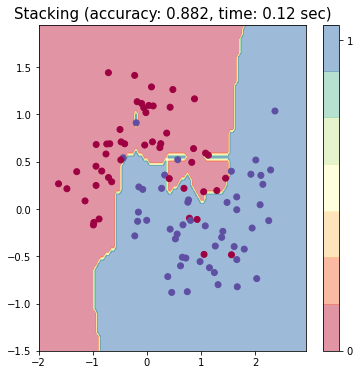

In [6]:
clf = StackingClassifier(estimators=[('lr', clf_svc), ('rf', clf_dt), ('gnb', clf_lr)],
                         final_estimator=LogisticRegression(),
                         cv=5)

fig, axs = plt.subplots(1, 1, figsize=(6, 6))

clf, axs_no = clf_1, 0
time_now = time.time()
clf.fit(tr_x, tr_y)
p = clf.predict(zz)
p = p.reshape((xx.shape[0], xx.shape[1]))
cax = axs.contourf(xx, yy, p[:,:], alpha=0.5, cmap=plt.cm.Spectral)
cbar = plt.colorbar(cax, ticks=[-1, 0, 1], ax=axs)
axs.scatter(tr_x[:,0], tr_x[:,1], c=tr_y,cmap=plt.cm.Spectral)
axs.set_title(f'Stacking (accuracy: {clf.score(ts_x, ts_y)}, time: {(time.time() - time_now):.2f} sec)', fontsize=15)

# Bagging

In [7]:
clf_svc_bagging = BaggingClassifier(SVC(C=100000, gamma='scale', probability=True), n_estimators=100, max_samples=1.0)
clf_dt_bagging = BaggingClassifier(DecisionTreeClassifier(), n_estimators=100, max_samples=1.0)
clf_lr_bagging = BaggingClassifier(LogisticRegression(C=10000, solver='lbfgs'), n_estimators=100, max_samples=1.0)

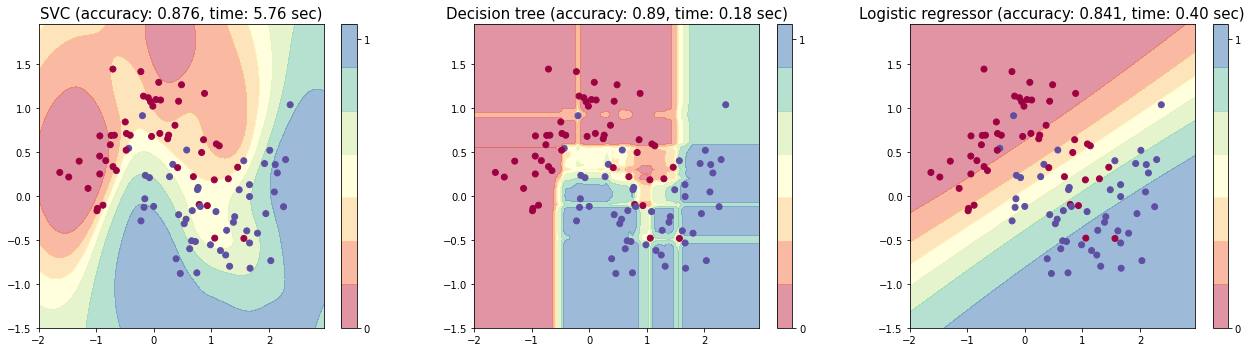

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

clf, axs_no = clf_svc_bagging, 0
time_now = time.time()
clf.fit(tr_x, tr_y)
p = clf.predict_proba(zz)
p = p.reshape((xx.shape[0], xx.shape[1], 2))
cax = axs[axs_no].contourf(xx, yy, p[:,:,1], alpha=0.5, cmap=plt.cm.Spectral)
cbar = plt.colorbar(cax, ticks=[-1, 0, 1], ax=axs[axs_no])
axs[axs_no].scatter(tr_x[:,0], tr_x[:,1], c=tr_y,cmap=plt.cm.Spectral)
axs[axs_no].set_title(f'SVC (accuracy: {clf.score(ts_x, ts_y)}, time: {(time.time() - time_now):.2f} sec)', fontsize=15)

clf, axs_no = clf_dt_bagging, 1
time_now = time.time()
clf.fit(tr_x, tr_y)
p = clf.predict_proba(zz)
p = p.reshape((xx.shape[0], xx.shape[1], 2))
cax = axs[axs_no].contourf(xx, yy, p[:,:,1], alpha=0.5, cmap=plt.cm.Spectral)
cbar = plt.colorbar(cax, ticks=[-1, 0, 1], ax=axs[axs_no])
axs[axs_no].scatter(tr_x[:,0], tr_x[:,1], c=tr_y,cmap=plt.cm.Spectral)
axs[axs_no].set_title(f'Decision tree (accuracy: {clf.score(ts_x, ts_y)}, time: {(time.time() - time_now):.2f} sec)', fontsize=15)

clf, axs_no = clf_lr_bagging, 2
time_now = time.time()
clf.fit(tr_x, tr_y)
p = clf.predict_proba(zz)
p = p.reshape((xx.shape[0], xx.shape[1], 2))
cax = axs[axs_no].contourf(xx, yy, p[:,:,1], alpha=0.5, cmap=plt.cm.Spectral)
cbar = plt.colorbar(cax, ticks=[-1, 0, 1], ax=axs[axs_no])
axs[axs_no].scatter(tr_x[:,0], tr_x[:,1], c=tr_y,cmap=plt.cm.Spectral)
axs[axs_no].set_title(f'Logistic regressor (accuracy: {clf.score(ts_x, ts_y)}, time: {(time.time() - time_now):.2f} sec)', fontsize=15)

plt.tight_layout()

# Boosting

In [9]:
clf_svc_boosting = AdaBoostClassifier(SVC(C=100000, gamma='scale', probability=True), n_estimators=50, learning_rate = 0.1)
clf_dt_boosting = AdaBoostClassifier(DecisionTreeClassifier(), n_estimators=50, learning_rate = 0.1)
clf_lr_boosting = AdaBoostClassifier(LogisticRegression(C=10000, solver='lbfgs'), n_estimators=50, learning_rate = 0.1)

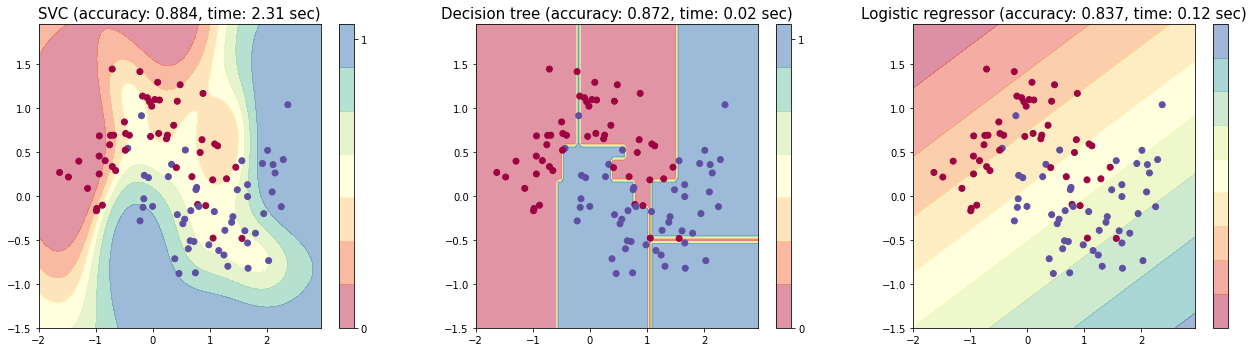

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

clf, axs_no = clf_svc_boosting, 0
time_now = time.time()
clf.fit(tr_x, tr_y)
p = clf.predict_proba(zz)
p = p.reshape((xx.shape[0], xx.shape[1], 2))
cax = axs[axs_no].contourf(xx, yy, p[:,:,1], alpha=0.5, cmap=plt.cm.Spectral)
cbar = plt.colorbar(cax, ticks=[-1, 0, 1], ax=axs[axs_no])
axs[axs_no].scatter(tr_x[:,0], tr_x[:,1], c=tr_y,cmap=plt.cm.Spectral)
axs[axs_no].set_title(f'SVC (accuracy: {clf.score(ts_x, ts_y)}, time: {(time.time() - time_now):.2f} sec)', fontsize=15)

clf, axs_no = clf_dt_boosting, 1
time_now = time.time()
clf.fit(tr_x, tr_y)
p = clf.predict_proba(zz)
p = p.reshape((xx.shape[0], xx.shape[1], 2))
cax = axs[axs_no].contourf(xx, yy, p[:,:,1], alpha=0.5, cmap=plt.cm.Spectral)
cbar = plt.colorbar(cax, ticks=[-1, 0, 1], ax=axs[axs_no])
axs[axs_no].scatter(tr_x[:,0], tr_x[:,1], c=tr_y,cmap=plt.cm.Spectral)
axs[axs_no].set_title(f'Decision tree (accuracy: {clf.score(ts_x, ts_y)}, time: {(time.time() - time_now):.2f} sec)', fontsize=15)

clf, axs_no = clf_lr_boosting, 2
time_now = time.time()
clf.fit(tr_x, tr_y)
p = clf.predict_proba(zz)
p = p.reshape((xx.shape[0], xx.shape[1], 2))
cax = axs[axs_no].contourf(xx, yy, p[:,:,1], alpha=0.5, cmap=plt.cm.Spectral)
cbar = plt.colorbar(cax, ticks=[-1, 0, 1], ax=axs[axs_no])
axs[axs_no].scatter(tr_x[:,0], tr_x[:,1], c=tr_y,cmap=plt.cm.Spectral)
axs[axs_no].set_title(f'Logistic regressor (accuracy: {clf.score(ts_x, ts_y)}, time: {(time.time() - time_now):.2f} sec)', fontsize=15)

plt.tight_layout()

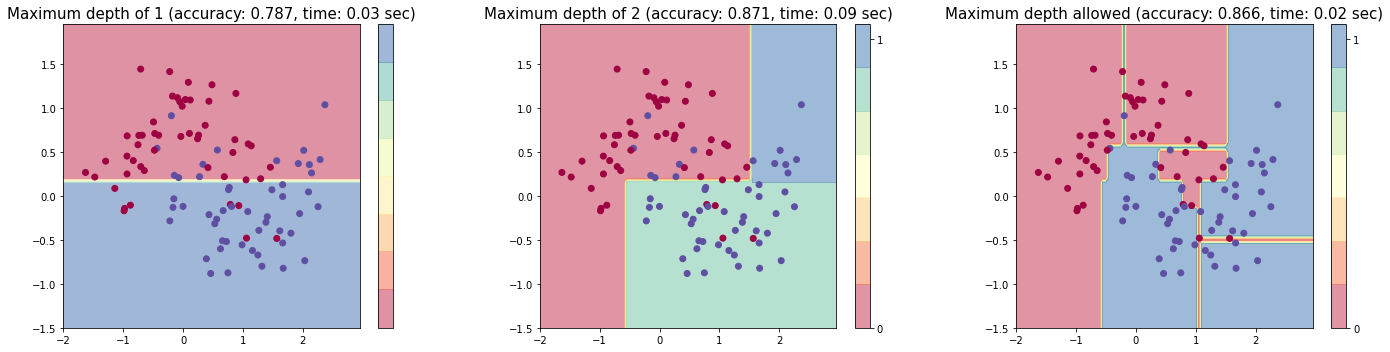

In [33]:
clf_dt_1 = DecisionTreeClassifier(max_depth=1)
clf_dt_2 = DecisionTreeClassifier(max_depth=2)
clf_dt_3 = DecisionTreeClassifier()

fig, axs = plt.subplots(1, 3, figsize=(20, 5))

clf, axs_no = clf_dt_boosting_1, 0
time_now = time.time()
clf.fit(tr_x, tr_y)
p = clf.predict_proba(zz)
p = p.reshape((xx.shape[0], xx.shape[1], 2))
cax = axs[axs_no].contourf(xx, yy, p[:,:,1], alpha=0.5, cmap=plt.cm.Spectral)
cbar = plt.colorbar(cax, ticks=[-1, 0, 1], ax=axs[axs_no])
axs[axs_no].scatter(tr_x[:,0], tr_x[:,1], c=tr_y,cmap=plt.cm.Spectral)
axs[axs_no].set_title(f'Maximum depth of 1 (accuracy: {clf.score(ts_x, ts_y)}, time: {(time.time() - time_now):.2f} sec)', fontsize=15)

clf, axs_no = clf_dt_boosting_2, 1
time_now = time.time()
clf.fit(tr_x, tr_y)
p = clf.predict_proba(zz)
p = p.reshape((xx.shape[0], xx.shape[1], 2))
cax = axs[axs_no].contourf(xx, yy, p[:,:,1], alpha=0.5, cmap=plt.cm.Spectral)
cbar = plt.colorbar(cax, ticks=[-1, 0, 1], ax=axs[axs_no])
axs[axs_no].scatter(tr_x[:,0], tr_x[:,1], c=tr_y,cmap=plt.cm.Spectral)
axs[axs_no].set_title(f'Maximum depth of 2 (accuracy: {clf.score(ts_x, ts_y)}, time: {(time.time() - time_now):.2f} sec)', fontsize=15)

clf, axs_no = clf_dt_boosting_3, 2
time_now = time.time()
clf.fit(tr_x, tr_y)
p = clf.predict_proba(zz)
p = p.reshape((xx.shape[0], xx.shape[1], 2))
cax = axs[axs_no].contourf(xx, yy, p[:,:,1], alpha=0.5, cmap=plt.cm.Spectral)
cbar = plt.colorbar(cax, ticks=[-1, 0, 1], ax=axs[axs_no])
axs[axs_no].scatter(tr_x[:,0], tr_x[:,1], c=tr_y,cmap=plt.cm.Spectral)
axs[axs_no].set_title(f'Maximum depth allowed (accuracy: {clf.score(ts_x, ts_y)}, time: {(time.time() - time_now):.2f} sec)', fontsize=15)

plt.tight_layout()

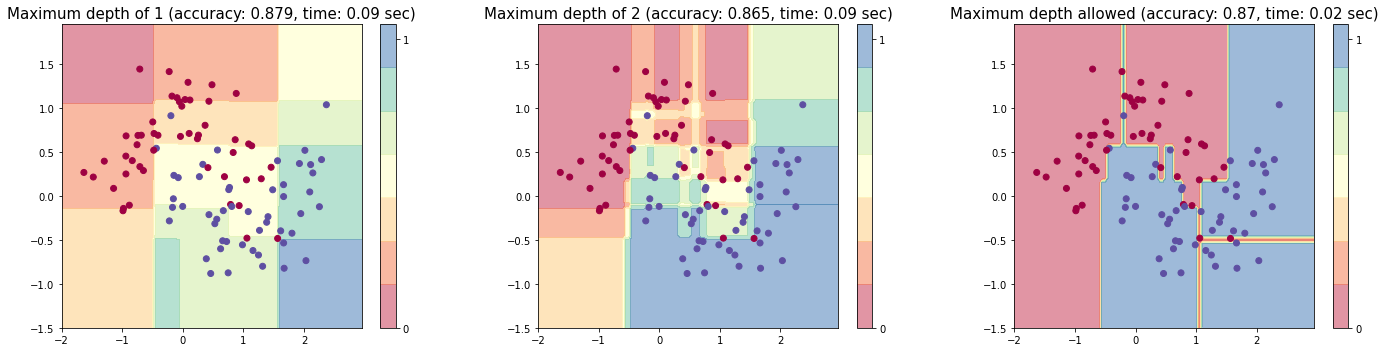

In [31]:
clf_dt_boosting_1 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=50, learning_rate = 0.1)
clf_dt_boosting_2 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2), n_estimators=50, learning_rate = 0.1)
clf_dt_boosting_3 = AdaBoostClassifier(DecisionTreeClassifier(), n_estimators=50, learning_rate = 0.1)

fig, axs = plt.subplots(1, 3, figsize=(20, 5))

clf, axs_no = clf_dt_boosting_1, 0
time_now = time.time()
clf.fit(tr_x, tr_y)
p = clf.predict_proba(zz)
p = p.reshape((xx.shape[0], xx.shape[1], 2))
cax = axs[axs_no].contourf(xx, yy, p[:,:,1], alpha=0.5, cmap=plt.cm.Spectral)
cbar = plt.colorbar(cax, ticks=[-1, 0, 1], ax=axs[axs_no])
axs[axs_no].scatter(tr_x[:,0], tr_x[:,1], c=tr_y,cmap=plt.cm.Spectral)
axs[axs_no].set_title(f'Maximum depth of 1 (accuracy: {clf.score(ts_x, ts_y)}, time: {(time.time() - time_now):.2f} sec)', fontsize=15)

clf, axs_no = clf_dt_boosting_2, 1
time_now = time.time()
clf.fit(tr_x, tr_y)
p = clf.predict_proba(zz)
p = p.reshape((xx.shape[0], xx.shape[1], 2))
cax = axs[axs_no].contourf(xx, yy, p[:,:,1], alpha=0.5, cmap=plt.cm.Spectral)
cbar = plt.colorbar(cax, ticks=[-1, 0, 1], ax=axs[axs_no])
axs[axs_no].scatter(tr_x[:,0], tr_x[:,1], c=tr_y,cmap=plt.cm.Spectral)
axs[axs_no].set_title(f'Maximum depth of 2 (accuracy: {clf.score(ts_x, ts_y)}, time: {(time.time() - time_now):.2f} sec)', fontsize=15)

clf, axs_no = clf_dt_boosting_3, 2
time_now = time.time()
clf.fit(tr_x, tr_y)
p = clf.predict_proba(zz)
p = p.reshape((xx.shape[0], xx.shape[1], 2))
cax = axs[axs_no].contourf(xx, yy, p[:,:,1], alpha=0.5, cmap=plt.cm.Spectral)
cbar = plt.colorbar(cax, ticks=[-1, 0, 1], ax=axs[axs_no])
axs[axs_no].scatter(tr_x[:,0], tr_x[:,1], c=tr_y,cmap=plt.cm.Spectral)
axs[axs_no].set_title(f'Maximum depth allowed (accuracy: {clf.score(ts_x, ts_y)}, time: {(time.time() - time_now):.2f} sec)', fontsize=15)

plt.tight_layout()